In [ ]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
!pip install datetime
import datetime

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape

def build_conv_net(in_shape, out_shape, n_downsampling_layers=4, filters=128, out_activation='sigmoid',verbose=1):
    """
    Build a basic convolutional network
    """
    model = tf.keras.Sequential()
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')

    model.add(Conv2D(input_shape=in_shape, **default_args, filters=filters))

    for _ in range(n_downsampling_layers):
        model.add(Conv2D(**default_args, filters=filters))

    model.add(Flatten())
    model.add(Dense(out_shape, activation=out_activation) )
    if verbose == 1:
        model.summary()
    return model


def build_deconv_net(latent_dim, n_upsampling_layers=4, filters=128, activation_out='sigmoid', size=(4,4), verbose=1):
    """
    Build a deconvolutional network for decoding/upscaling latent vectors

    When building the deconvolutional architecture, usually it is best to use the same layer sizes that
    were used in the downsampling network and the Conv2DTranspose layers are used instead of Conv2D layers.
    Using identical layers and hyperparameters ensures that the dimensionality of our output matches the
    shape of our input images.
    """

    model = tf.keras.Sequential()
    model.add(Dense(size[0] * size[1] * 64, input_dim=latent_dim))
    model.add(Reshape((size[0], size[1], 64))) # This matches the output size of the downsampling architecture
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')

    for i in range(n_upsampling_layers):
        model.add(Conv2DTranspose(**default_args, filters=filters))

    # This last convolutional layer converts back to 3 channel RGB image
    model.add(Conv2D(filters=3, kernel_size=(3,3), activation=activation_out, padding='same'))
    if verbose == 1:
        model.summary()
    return model


def build_gan(data_shape, latent_dim, filters=128, lr=0.0002, beta_1=0.5):
    optimizer = tf.optimizers.legacy.Adam(learning_rate=lr, beta_1=beta_1)

    # Usually thew GAN generator has tanh activation function in the output layer
    generator = build_deconv_net(latent_dim, activation_out='tanh', filters=filters)

    # Build and compile the discriminator
    discriminator = build_conv_net(in_shape=data_shape, out_shape=1, filters=filters) # Single output for binary classification
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

    # End-to-end GAN model for training the generator
    discriminator.trainable = False
    true_fake_prediction = discriminator(generator.output)
    GAN = tf.keras.Model(inputs=generator.input, outputs=true_fake_prediction)
    GAN = tf.keras.models.Sequential([generator, discriminator])
    GAN.compile(loss='binary_crossentropy', optimizer=optimizer)

    return discriminator, generator, GAN

class Sampling(tf.keras.layers.Layer):
    """
    Custom layer for the variational autoencoder
    It takes two vectors as input - one for means and other for variances of the latent variables described by a multimodal gaussian
    Its output is a latent vector randomly sampled from this distribution
    """
    def call(self, inputs):
        z_mean, z_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_var) * epsilon

def build_vae(data_shape, latent_dim, filters=128, size=(4,4), verbose=1):

    # Building the encoder - starts with a simple downsampling convolutional network
    encoder = build_conv_net(data_shape, latent_dim*2, filters=filters, verbose=verbose)

    # Adding special sampling layer that uses the reparametrization trick
    z_mean = Dense(latent_dim)(encoder.output)
    z_var = Dense(latent_dim)(encoder.output)
    z = Sampling()([z_mean, z_var])

    # Connecting the two encoder parts
    encoder = tf.keras.Model(inputs=encoder.input, outputs=z)

    # Defining the decoder which is a regular upsampling deconvolutional network
    decoder = build_deconv_net(latent_dim, activation_out='sigmoid', filters=filters,size=size, verbose=verbose)
    vae = tf.keras.Model(inputs=encoder.input, outputs=decoder(z))

    # Adding the special loss term
    kl_loss = -0.5 * tf.reduce_sum(z_var - tf.square(z_mean) - tf.exp(z_var) + 1)
    vae.add_loss(kl_loss/tf.cast(tf.keras.backend.prod(data_shape), tf.float32))

    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy')

    vae.decoder = decoder

    return encoder, decoder, vae


# strategy = tf.distribute.MirroredStrategy()

# # Open a strategy scope.
# with strategy.scope():
#     # Everything that creates variables should be under the strategy scope.
#     # In general this is only model construction & `compile()`.
#     model = Model(...)
#     model.compile(...)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.1/247.1 kB 18.0 MB/s eta 0:00:00


In [ ]:
def grid_plot(images, n=3, wspace=0, hspace=0,name=None):
    for index in range(n * n):
        plt.subplot(n, n, 1 + index)
        plt.axis('off')
        plt.imshow(images[index])
    fig = plt.gcf()
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    fig.suptitle(name, fontsize=14)
    plt.show()

In [ ]:
import os
import pathlib

data_dir = pathlib.Path('/kaggle/working/cat/')

filelist = list(data_dir.glob('*'))
for file in filelist:
#     if str(file).find('vae_cat_bs64_ld128_10-19-21:48') == -1 and file.is_file():
#         os.remove(file)
    print(file)


# dataset_path = '/kaggle/working/dataset'
# os.mkdir(dataset_path)

# os.rmdir(data_dir)
# os.remove('/kaggle/working/dataset/cat_(47219, 64, 64, 3)_10-18-20:07.npy')

In [ ]:
def generate_sample(n=64):
  (height, width) = (n, n)
  (pixels_per_square,) = (8,)

  stddev = 10
  image = np.zeros((height, width, 3), dtype=np.uint8)

  # Loop over each 8x8 square in the image
  for y in range(0, height, pixels_per_square):
      for x in range(0, width, pixels_per_square):
          color = (np.random.normal(0, 1, size=3) * 255).astype(np.uint8)
          # color = np.exp(-(x - pixels_per_square // 2)**2 / (2 * stddev**2)
                        # -(y - pixels_per_square // 2)**2 / (2 * stddev**2))

          image[y:y + pixels_per_square, x:x + pixels_per_square, :] = color
  return image

def generate_samples(n=5000):
    # Since the image is not complicated, we do not need too many samples

    dimension = 64
    X = np.zeros((n, dimension, dimension, 3), dtype=np.uint8)
    for i in range(n):
      X[i] = generate_sample()
    return X

r_dataset = generate_samples(9)
grid_plot(r_dataset[np.arange(9)], name='dataset (64x64x3)', n=3)

In [ ]:
# Training the VAE model
r_dataset = generate_samples(5000)
latent_dim = 32
print(r_dataset.shape[1:])
encoder, decoder, vae = build_vae(r_dataset.shape[1:], latent_dim, filters=128)

# Generate random vectors that we will use to sample our latent space
for epoch in range(20):
    vae.fit(x=r_dataset, y=r_dataset, epochs=1, batch_size=8)

    latent_vectors = np.random.randn(9, latent_dim)
    images = decoder(latent_vectors)
    grid_plot(images, epoch, name='VAE generated images (randomly sampled from the latent space)', n=3, save=False)

# Abstract_gallery

In [ ]:
# get images of the dataset and save the decoded data
# !!!run this only if you want to generate new decoded data

import pathlib
import skimage

data_dir = pathlib.Path('/kaggle/input/abstract-art-gallery/Abstract_gallery/Abstract_gallery')

filelist = list(data_dir.glob('*.jpg'))

print(len(filelist), skimage.io.imread(filelist[0]).shape)

# filelist = filelist[:2000]
X = np.array([np.array(skimage.transform.resize(skimage.io.imread(fname),(64,64))) for fname in filelist])
time = datetime.datetime.now().strftime('%m-%d-%H:%M')
dataset_path = f'/kaggle/working/dataset/art_{X.shape}_{time}.npy'
np.save(dataset_path,X)

a_dataset = X
grid_plot(a_dataset[np.random.randint(0, 2000, 9)])

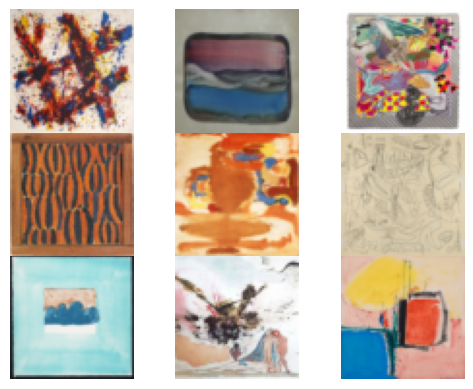

In [ ]:
data_path = '/kaggle/working/dataset/art_(2782, 64, 64, 3)_10-20-16:13.npy'
a_dataset = np.load(data_path)
grid_plot(a_dataset[np.random.randint(0, 2000, 9)])

In [ ]:
# Training the VAE model
latent_dim = 64
batch_size = 4
epochs = 20
encoder, decoder, vae = build_vae(a_dataset.shape[1:], latent_dim, filters=128)

#16: /kaggle/working/art/vae_art_bs16_ld64_10-20-16:21.tf
#8: /kaggle/working/art/vae_art_bs8_ld64_10-20-16:23.tf
#4: /kaggle/working/art/vae_art_bs4_ld64_10-20-16:32.tf
# weights_path = '/kaggle/working/art/vae_art_bs4_ld64_10-20-16:29.tf'
# vae.load_weights(weights_path)
# latent_vectors = np.random.randn(9, latent_dim)
# images = decoder(latent_vectors)
# grid_plot(images)

for epoch in range(epochs):
    vae.fit(x=a_dataset, y=a_dataset, epochs=1, batch_size=batch_size)

    path = '/kaggle/working/art/'
    file_name = f'vae_art_bs{batch_size}_ld{latent_dim}'
    time = datetime.datetime.now().strftime('%m-%d-%H:%M')
    file_path = path + f'{file_name}' + f'_{time}.tf'
    print(file_path)
    vae.save_weights(file_path)

    latent_vectors = np.random.randn(4, latent_dim)
    images = decoder(latent_vectors)
    grid_plot(images, n=2, name=f'{epoch+1}/{epochs}')

# Pokemon

In [ ]:
# get images of the dataset and save the decoded data
# !!!run this only if you want to generate new decoded data

import pathlib
import skimage

data_dir = pathlib.Path('/kaggle/input/pokemon-images-dataset/pokemon_jpg/pokemon_jpg')

filelist = list(data_dir.glob('*.jpg'))

data_dir = pathlib.Path('/kaggle/input/pokemonclassification/PokemonData')
dirlist = list(data_dir.glob('*'))
for dir in dirlist:
    filelist += list(dir.glob('*.jpg'))

print(len(filelist), skimage.io.imread(filelist[0]).shape)

# filelist = filelist[:20]
images = []
i = 0
for file in filelist:
    image = np.array(skimage.transform.resize(skimage.io.imread(file),(64,64)))
    if len(image.shape) < 3:
        continue
    images.append(image)
    i += 1
X = np.array(images)
print(X.shape)
a_dataset = X
grid_plot(a_dataset[np.random.randint(0, 20, 9)])

time = datetime.datetime.now().strftime('%m-%d-%H:%M')
dataset_path = f'/kaggle/working/dataset/pokmon_{X.shape}_{time}.npy'
np.save(dataset_path,X)

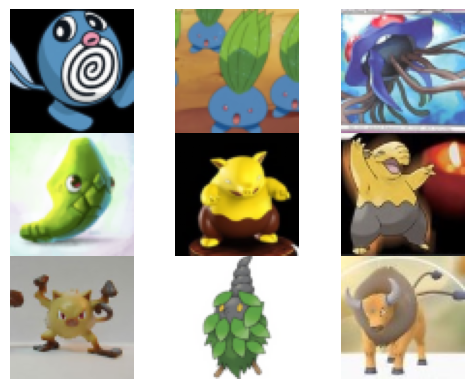

In [ ]:
data_path = '/kaggle/working/dataset/pokmon_(7475, 64, 64, 3)_10-20-17:25.npy'
a_dataset = np.load(data_path)
grid_plot(a_dataset[np.random.randint(0, 2000, 9)])

In [ ]:
# Training the VAE model
latent_dim = 128
batch_size = 16
epochs = 30
encoder, decoder, vae = build_vae(a_dataset.shape[1:], latent_dim, filters=128)

#16 : /kaggle/working/pokemon/vae_pokemon_bs16_ld128_10-20-17:49.tf
weights_path = '/kaggle/working/pokemon/vae_pokemon_bs16_ld128_10-20-17:49.tf'
vae.load_weights(weights_path)
latent_vectors = np.random.randn(9, latent_dim)
images = decoder(latent_vectors)
grid_plot(images)

# Generate random vectors that we will use to sample our latent space
for epoch in range(epochs):
    vae.fit(x=a_dataset, y=a_dataset, epochs=1, batch_size=batch_size)

    path = '/kaggle/working/pokemon/'
    file_name = f'vae_pokemon_bs{batch_size}_ld{latent_dim}'
    time = datetime.datetime.now().strftime('%m-%d-%H:%M')
    file_path = path + f'{file_name}' + f'_{time}.tf'
    print(file_path)
    vae.save_weights(file_path)

    latent_vectors = np.random.randn(4, latent_dim)
    images = decoder(latent_vectors)
    grid_plot(images, n=2, name=f'{epoch+1}/{epochs}')

# Avatar

In [ ]:
# get images of the dataset and save the decoded data
# !!!run this only if you want to generate new decoded data
import pathlib
import skimage

data_dir = pathlib.Path('/kaggle/input/cartoon-avatar/data')

filelist = list(data_dir.glob('*.png'))

print(len(filelist), skimage.io.imread(filelist[0]).shape)

filelist = filelist[:20000]
X = np.array([np.array(skimage.transform.resize(skimage.io.imread(fname),(64,64)))[:,:,:3] for fname in filelist])
a_dataset = X
grid_plot(a_dataset[np.random.randint(0, 2000, 9)])

time = datetime.datetime.now().strftime('%m-%d-%H:%M')
dataset_path = f'/kaggle/working/dataset/avatar_{X.shape}_{time}.npy'
np.save(dataset_path,X)

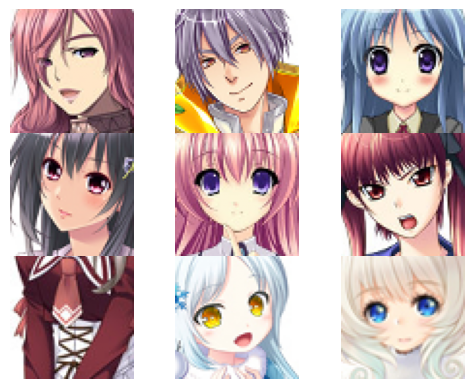

In [ ]:
data_carton_path = '/kaggle/working/dataset/avatar_(20000, 64, 64, 3)_10-20-16:57.npy'
a_dataset = np.load(data_carton_path)
grid_plot(a_dataset[np.random.randint(0, 2000, 9)])

In [ ]:
# Training the VAE model
latent_dim = 128
batch_size = 32
epochs = 10
encoder, decoder, vae = build_vae(a_dataset.shape[1:], latent_dim, filters=128)


# 32 : /kaggle/working/avatar/vae_avatar_bs32_ld128_10-20-17:08.tf
weights_path = '/kaggle/working/avatar/vae_avatar_bs32_ld128_10-20-17:08.tf'
vae.load_weights(weights_path)
latent_vectors = np.random.randn(9, latent_dim)
images = decoder(latent_vectors)
grid_plot(images)

# Generate random vectors that we will use to sample our latent space
for epoch in range(epochs):
    vae.fit(x=a_dataset, y=a_dataset, epochs=1, batch_size=batch_size)

    path = '/kaggle/working/avatar/'
    file_name = f'vae_avatar_bs{batch_size}_ld{latent_dim}'
    time = datetime.datetime.now().strftime('%m-%d-%H:%M')
    file_path = path + f'{file_name}' + f'_{time}.tf'
    print(file_path)
    vae.save_weights(file_path)

    latent_vectors = np.random.randn(4, latent_dim)
    images = decoder(latent_vectors)
    grid_plot(images, n=2, name=f'{epoch+1}/{epochs}')

# Cat

In [ ]:
# get images of the dataset and save the decoded data
# !!!run this only if you want to generate new decoded data
import pathlib
import skimage
from random import sample

data_dir = pathlib.Path('/kaggle/input/cat-face/data/cat_face')
filelist = list(data_dir.glob('*.jpg'))

print(len(filelist), skimage.io.imread(filelist[0]).shape)

filelist = sample(filelist, 20000)
X = np.array([np.array(skimage.transform.resize(skimage.io.imread(fname),(64,64)))[:,:,:3] for fname in filelist])

a_dataset = X
grid_plot(a_dataset[np.random.randint(0, 2000, 9)])

time = datetime.datetime.now().strftime('%m-%d-%H:%M')
dataset_path = f'/kaggle/working/dataset/cat_{X.shape}_{time}.npy'
np.save(dataset_path,X)

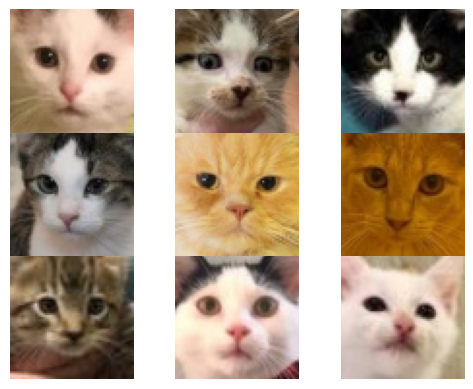

In [ ]:
data_path = '/kaggle/working/dataset/cat_(20000, 64, 64, 3)_10-19-22:24.npy'
a_dataset = np.load(data_path)
grid_plot(a_dataset[np.random.randint(0, 2000, 9)])

In [ ]:
# Training the VAE model
latent_dim = 128
batch_size = 8
epochs = 10
encoder, decoder, vae = build_vae(a_dataset.shape[1:], latent_dim, filters=128)

# checkpoint-32 : /kaggle/working/cat/vae_cat_bs32_ld128_10-19-22:31.tf
# checkpoint-16 : /kaggle/working/cat/vae_cat_bs16_ld128_10-20-16:42.tf
# checkpoint-8 : /kaggle/working/cat/vae_cat_bs8_ld128_10-20-16:52.tf

# weights_path = '/kaggle/working/cat/vae_cat_bs16_ld128_10-20-16:42.tf'
# vae.load_weights(weights_path)
# latent_vectors = np.random.randn(9, latent_dim)
# images = decoder(latent_vectors)
# grid_plot(images)

# Generate random vectors that we will use to sample our latent space
for epoch in range(epochs):
    vae.fit(x=a_dataset, y=a_dataset, epochs=1, batch_size=batch_size)

    path = '/kaggle/working/cat/'
    file_name = f'vae_cat_bs{batch_size}_ld{latent_dim}'
    time = datetime.datetime.now().strftime('%m-%d-%H:%M')
    file_path = path + f'{file_name}' + f'_{time}.tf'
    print(file_path)
    vae.save_weights(file_path)

    latent_vectors = np.random.randn(4, latent_dim)
    images = decoder(latent_vectors)
    grid_plot(images, n=2, name=f'{epoch+1}/{epochs}')

# Latent Space

In [ ]:
# get a random orthogonal vectors of A
def orthogonal_randn(A):
    # select the dimension which need to be calculated
    index_for_remove = np.random.randint(0,len(A),1)
    # print(index_for_remove)

    c_A = np.delete(A,index_for_remove)
    # generate values for other dimensions
    c_B = np.random.randn(len(A)-1)

    # calculate the remaining one b_r
    # sum(a_i * b_i) + a_r * b_r = 0
    r = (0 - c_A.dot(c_B.T))/A[index_for_remove]

    B = np.insert(c_B, index_for_remove, r)
    return B

# get a latent space
def randn_orthogonal_space(n, latent_dim):
    # generate two points randomly
    A,B = np.random.randn(2, latent_dim)
    # distanct of the vector AB
    d_AB = np.sqrt(np.sum((B-A)**2))

    # get the orthogonal vector of AB and scale it based on d_AB
    O_BA = orthogonal_randn(B-A)
    O_BA = (O_BA / np.sqrt(np.sum((O_BA)**2))) * d_AB

    # generate interpolated values. v is the propartion.
    interval = 1 / n
    interpolate_values = np.arange(0,1,interval)

    latent_vectors = []
    for i in range(n):
        v = interpolate_values[i]
        n_A = A + v * O_BA
        n_B = B + v * O_BA
        latent_vector = np.array([n_A + v * (n_B-n_A) for v in interpolate_values])
        latent_vectors.append(latent_vector)


    return np.array(latent_vectors)

def rand_linear_latent_vectors(n,latent_dim):
    # f(x)= A + x * (B - A)
    A,B = np.random.randn(2, latent_dim)
    interval = 1 / n
    interpolate_values = np.arange(0,1,interval)
    latent_vectors = np.array([A + v * (B-A) for v in interpolate_values])

    return latent_vectors

def plot_linear(weights_path,n,latent_dim,input_shape):
    latent_vectors = rand_linear_latent_vectors(n,latent_dim)
    encoder, decoder, vae = build_vae(input_shape, latent_dim, filters=128, verbose=0)
    vae.load_weights(weights_path)
    images = decoder(latent_vectors)
    grid_plot(images, n=int(np.sqrt(n)))

def plot_latent_space(weights_path, n, latent_dim,input_shape):
    # display an n*n 2D manifold of digits
    encoder, decoder, vae = build_vae(input_shape, latent_dim, filters=128, verbose=0)
    vae.load_weights(weights_path)
    latent_vectors = randn_orthogonal_space(n, latent_dim).reshape((n*n,latent_dim))
    images = decoder(latent_vectors)
    grid_plot(images, n=n, wspace=-0.7,hspace=0.1)

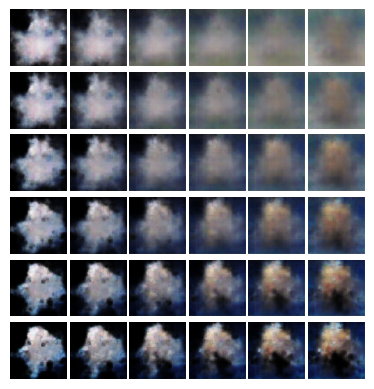

In [ ]:
#pokemon: /kaggle/working/pokemon/vae_pokemon_bs16_ld128_10-20-17:49.tf
latent_dim = 128
input_shape = a_dataset.shape[1:]
weights_path = '/kaggle/working/pokemon/vae_pokemon_bs16_ld128_10-20-17:49.tf'

# plot_linear(weights_path,16,latent_dim=latent_dim, input_shape=input_shape)
plot_latent_space(weights_path,6,latent_dim=latent_dim, input_shape=input_shape)

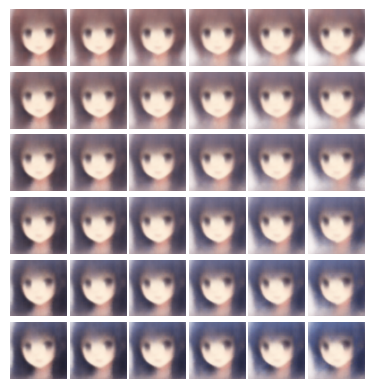

In [ ]:
#avatar: /kaggle/working/avatar/vae_avatar_bs32_ld128_10-20-17:13.tf
latent_dim = 128
input_shape = a_dataset.shape[1:]
weights_path = '/kaggle/working/avatar/vae_avatar_bs32_ld128_10-20-17:13.tf'

# plot_linear(weights_path,16,latent_dim=latent_dim, input_shape=input_shape)
plot_latent_space(weights_path,6,latent_dim=latent_dim, input_shape=input_shape)

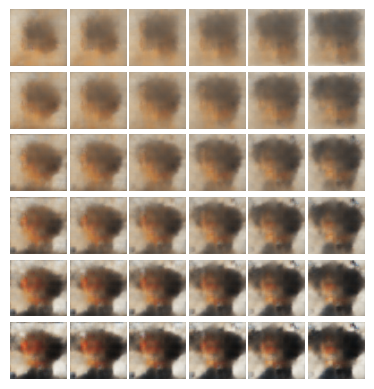

In [ ]:
#art: /kaggle/working/art/vae_art_bs4_ld64_10-20-16:32.tf
latent_dim = 64
input_shape = a_dataset.shape[1:]
weights_path = '/kaggle/working/art/vae_art_bs4_ld64_10-20-16:32.tf'

# plot_linear(weights_path,16,latent_dim=latent_dim, input_shape=input_shape)
plot_latent_space(weights_path,6,latent_dim=latent_dim, input_shape=input_shape)

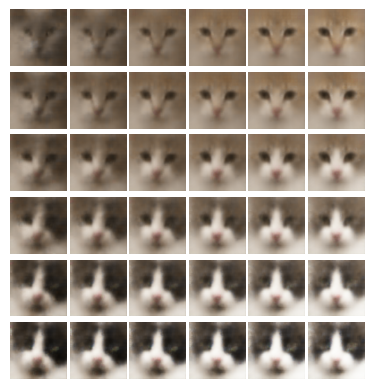

In [ ]:
#cat: /kaggle/working/cat/vae_cat_bs8_ld128_10-20-16:52.tf
latent_dim = 128
input_shape = a_dataset.shape[1:]
weights_path = '/kaggle/working/cat/vae_cat_bs8_ld128_10-20-16:52.tf'

# plot_linear(weights_path,16,latent_dim=latent_dim, input_shape=input_shape)
plot_latent_space(weights_path,6,latent_dim=latent_dim, input_shape=input_shape)